# **Cargado de archivos**

In [1]:
# =============================================================================
# Configuración optimizada de la sesión de Spark
# =============================================================================
# Esta configuración es más robusta para conjuntos de datos grandes.
# Debe ejecutarse una vez al inicio del notebook.

from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("BlueBikes-Project") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Establecer variables de entorno para que PySpark funcione correctamente en algunos entornos
import sys
# os.environ["PYSPARK_PYTHON"] = sys.executable
# os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

In [2]:
# =============================================================================
# Cargar DataFrame procesado desde Google Drive (para Colab)
# =============================================================================
# Esta celda activa tu Google Drive y lee los datos procesados del archivo Parquet almacenado allí.
# Usarlo en el entorno de Google Colab.

from google.colab import drive

print("Intentando montar Google Drive...")
try:
    drive.mount('/content/drive')

    gdrive_path = "/content/drive/MyDrive/BlueBikes_PRJ/df_final_bluebikes_v1.parquet"
    print(f"Cargando datos desde la ruta de Google Drive: {gdrive_path}")

    # Spark leerá la carpeta Parquet directamente
    df_final = spark.read.parquet(gdrive_path)

    print("✅ DataFrame cargado exitosamente desde Google Drive.")

    # Verify the schema and show a few rows
    print("Esquema de DataFrame:")
    df_final.printSchema()

    print("Muestra de los datos cargados:")
    df_final.show(5, truncate=False)

except Exception as e:
    print(f"❌ Error al cargar datos desde Google Drive. Asegúrate de que el archivo exista en '{gdrive_path}'.")
    print(f"Detalles del error: {e}")

Intentando montar Google Drive...
Mounted at /content/drive
Cargando datos desde la ruta de Google Drive: /content/drive/MyDrive/BlueBikes_PRJ/df_final_bluebikes_v1.parquet
✅ DataFrame cargado exitosamente desde Google Drive.
Esquema de DataFrame:
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- duration_sec: long (nullable = true)
 |-- schema_version: string (nullable = true)
 |-- periodo: string (nullable = true)

Muestra de los datos cargados:
+----------------+-------------+-----------------------+-----------------------+---------------------------------

# **Ingeniería de Características**

In [3]:
import pyspark.sql.functions as F

# Asegura tipos y una columna de fecha base para los flags
df_final = (
    df_final
    .withColumn("start_lat", F.col("start_lat").cast("double"))
    .withColumn("start_lng", F.col("start_lng").cast("double"))
    .withColumn("end_lat",   F.col("end_lat").cast("double"))
    .withColumn("end_lng",   F.col("end_lng").cast("double"))
    .withColumn("started_at", F.to_timestamp("started_at"))
    .withColumn("ended_at",   F.to_timestamp("ended_at"))
)

## Conversión a Zona Horaria de Boston (hora y truncado a hora)

In [4]:
import pyspark.sql.functions as F

# asegurar tipo timestamp
df_final = (df_final
    .withColumn("started_at", F.to_timestamp("started_at"))
    .withColumn("ended_at",   F.to_timestamp("ended_at"))
)

# === A) si tus timestamps están en UTC → conviértelos a Boston ===
df_final = df_final.withColumn(
    "started_at_local",
    F.from_utc_timestamp("started_at", "America/New_York")
)
# === B) si YA están en hora local, usa esta en lugar de A
df_final = (df_final
    .withColumn("ts_hour", F.date_trunc("hour", F.col("started_at_local")))  # inicio de la hora
)

## Ingeniería de características temporales

In [5]:
# Extraeremos varias características basadas en el tiempo de la marca de tiempo 'started_at'.
# Esto ayudará al modelo a capturar patrones relacionados con la hora del día, la semana y el año.

from pyspark.sql.functions import col, year, month, dayofweek, hour, dayofyear, weekofyear, when, sin, cos, radians, date_format
import numpy as np

# Extraer características temporales básicas
df_with_temporal = df_final \
    .withColumn('trip_date', col('started_at_local').cast('date')) \
    .withColumn('trip_year', year(col('started_at_local'))) \
    .withColumn('trip_month', month(col('started_at_local'))) \
    .withColumn('trip_day_of_week', dayofweek(col('started_at_local'))) \
    .withColumn('trip_hour', hour(col('started_at_local'))) \
    .withColumn('is_weekend', when(col('trip_day_of_week').isin([1, 7]), 1).otherwise(0))

# Definir estaciones según los meses
df_with_temporal = df_with_temporal.withColumn(
    'season',
    when(col('trip_month').isin([12, 1, 2]), 'winter')
    .when(col('trip_month').isin([3, 4, 5]), 'spring')
    .when(col('trip_month').isin([6, 7, 8]), 'summer')
    .otherwise('fall')
)

# Codificar características cíclicas (hora y día de la semana) mediante transformaciones de seno y coseno.
# Esto ayuda al modelo a comprender la naturaleza continua del tiempo.
# Ciclo horario (24 horas)
df_with_temporal = df_with_temporal \
    .withColumn('hour_sin', sin(2 * np.pi * col('trip_hour') / 24)) \
    .withColumn('hour_cos', cos(2 * np.pi * col('trip_hour') / 24))

# Ciclo de día de la semana (7 días)
df_with_temporal = df_with_temporal \
    .withColumn('day_of_week_sin', sin(2 * np.pi * col('trip_day_of_week') / 7)) \
    .withColumn('day_of_week_cos', cos(2 * np.pi * col('trip_day_of_week') / 7))

# Actualizar el DataFrame principal
df_final = df_with_temporal

## Ingeniería de características geoespaciales

In [6]:
# Crearemos nuevas funciones basadas en las coordenadas de la estación para capturar patrones geoespaciales.
# La distancia de Haversine es una función clave para predecir la duración del viaje.
# También crearemos funciones relacionadas con la popularidad/densidad de la estación.

from pyspark.sql.functions import udf, lit, count
from pyspark.sql.types import DoubleType
from math import radians, sin, cos, sqrt, atan2

# Distancia de Haversina UDF
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0 # Radio de la Tierra en km

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

haversine_udf = udf(haversine, DoubleType())

# Calcular la distancia haversina entre las estaciones inicial y final
df_with_geospatial = df_final.withColumn(
    'haversine_distance_km',
    haversine_udf(
        col('start_lng'), col('start_lat'),
        col('end_lng'), col('end_lat')
    )
)

# Función: Calcular indicadores de "estación popular" según el historial de viajes.
# Definiremos una estación como popular si su total de viajes se encuentra en el 10% superior.
trip_counts_by_station = df_with_geospatial.groupBy('start_station_name').agg(count('*').alias('trip_count'))
percentile_threshold = trip_counts_by_station.approxQuantile('trip_count', [0.90], 0.05)[0]

popular_stations = trip_counts_by_station.filter(col('trip_count') > percentile_threshold) \
    .select('start_station_name').withColumn('is_popular_start', lit(1))

# Une el flag binario de la estación popular al DataFrame principal
df_with_geospatial = df_with_geospatial.join(
    popular_stations,
    on='start_station_name',
    how='left'
).fillna(0, subset=['is_popular_start'])

# Actualizar el DataFrame principal
df_final = df_with_geospatial

## Ingeniería de características de interacción

In [7]:
# Crearemos características de interacción que capturen relaciones entre variables existentes,
# como la velocidad del viaje y si el viaje fue de ida y vuelta.

from pyspark.sql.functions import col, when

# Crear una característica para la velocidad promedio en km/h
# Se añade una pequeña constante (1e-6) al denominador para evitar la división por cero,
df_with_interaction_features = df_final.withColumn(
    "avg_speed_kmh",
    col("haversine_distance_km") / (col("duration_sec") / 3600 + 1e-6)
)

# Crear una característica binaria para viajes de ida y vuelta (misma estación de inicio y fin)
df_with_interaction_features = df_with_interaction_features.withColumn(
    "is_round_trip",
    when(col("start_station_name") == col("end_station_name"), 1).otherwise(0)
)


# Actualizar el DataFrame principal para incluir estas nuevas características
df_final = df_with_interaction_features

## Feriados Massachusetts (USA): is_holiday

In [8]:
import pyspark.sql.functions as F
import datetime as dt

# A) rango de años presentes
mm = df_final.agg(F.min("trip_date").alias("min_d"), F.max("trip_date").alias("max_d")).first()
years = list(range(mm["min_d"].year, mm["max_d"].year + 1))

# B) construir calendario de feriados (Massachusetts)
try:
    import holidays
except ImportError as e:
    raise RuntimeError("Instala el paquete 'holidays' con: pip install holidays") from e

us_ma = holidays.US(subdiv="MA", years=years)  # incluye 'observed'
holiday_dates = sorted(us_ma.keys())

# C) tabla de feriados -> Spark
holiday_df = (
    spark.createDataFrame([(d.isoformat(),) for d in holiday_dates], ["date_str"])
         .select(F.to_date("date_str").alias("trip_date"))
         .withColumn("is_holiday", F.lit(True))
)

# D) unir al hecho por fecha
df_final = (
    df_final
    .join(holiday_df, on="trip_date", how="left")
    .withColumn("is_holiday", F.coalesce("is_holiday", F.lit(False)).cast("integer")) # Cast boolean a entero (0 o 1)
)

## Columnas creadas

In [9]:
# Lista de columnas originales basadas en el esquema
original_cols = [
    'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name',
    'start_lat', 'start_lng', 'end_station_name', 'end_lat', 'end_lng',
    'member_casual', 'duration_sec', 'schema_version', 'periodo'
]

# Obtener la lista de todas las columnas en el DataFrame final
all_cols = df_final.columns

# Identificar las columnas creadas por la Ing. de Características excluyendo las columnas originales
feature_engineered_cols = [col for col in all_cols if col not in original_cols]

# Conteo del número de columnas agregadas por la Ing. de Características
num_feature_engineered_cols = len(feature_engineered_cols)
print(f"Cantidad de columnas agregadas por la Ing. de Características: {num_feature_engineered_cols}")

# Seleccionar y mostrar solo las columnas creadas por la Ing. de Características
df_final.select(feature_engineered_cols).show(5, truncate=False)

Cantidad de columnas agregadas por la Ing. de Características: 18
+----------+-----------------------+-------------------+---------+----------+----------------+---------+----------+------+----------------------+-------------------+-------------------+--------------------+---------------------+----------------+------------------+-------------+----------+
|trip_date |started_at_local       |ts_hour            |trip_year|trip_month|trip_day_of_week|trip_hour|is_weekend|season|hour_sin              |hour_cos           |day_of_week_sin    |day_of_week_cos     |haversine_distance_km|is_popular_start|avg_speed_kmh     |is_round_trip|is_holiday|
+----------+-----------------------+-------------------+---------+----------+----------------+---------+----------+------+----------------------+-------------------+-------------------+--------------------+---------------------+----------------+------------------+-------------+----------+
|2024-09-29|2024-09-29 05:33:59.648|2024-09-29 05:00:00|2024    

## Agregar datos por hora para forecast

In [13]:
from pyspark.sql import functions as F

# ===============================
# 1) Tu pipeline de agregación
# ===============================
df_hourly_station = (
    df_final
    .groupBy("ts_hour", "start_station_name",
             "trip_year", "trip_month", "trip_day_of_week", "trip_hour",
             "is_weekend", "is_holiday", "season")
    .agg(
        F.count("*").alias("rides"),
        F.countDistinct("ride_id").alias("unique_trips"),
        F.avg("duration_sec").alias("avg_dur_sec"),
        F.expr("percentile_approx(duration_sec, 0.5)").alias("median_dur_sec"),
        F.avg("avg_speed_kmh").alias("avg_speed_kmh"),
        F.sum("haversine_distance_km").alias("km_total"),
        F.sum(F.col("is_round_trip").cast("int")).alias("round_trips")
    )
)

df_user_type = (
    df_final
    .groupBy("ts_hour", "start_station_name")
    .pivot("member_casual", ["member","casual"])
    .agg(F.count("*"))
    .withColumnRenamed("member","rides_member")
    .withColumnRenamed("casual","rides_casual")
)

df_bike_type = (
    df_final
    .groupBy("ts_hour", "start_station_name")
    .pivot("rideable_type", ["classic_bike","electric_bike"])
    .agg(F.count("*"))
    .withColumnRenamed("classic_bike","rides_classic")
    .withColumnRenamed("electric_bike","rides_electric")
)

df_forecast_ready = (
    df_hourly_station
    .join(df_user_type, ["ts_hour","start_station_name"], "left")
    .join(df_bike_type, ["ts_hour","start_station_name"], "left")
    .fillna(0)
)

print("✅ Dataset agregado para forecasting por estación listo")

# ============================================================
# 2) Validación: filas resultantes y estimación de memoria
#    (rápido y seguro antes de toPandas)
# ============================================================

# El número de filas tras los joins/pivots debe ser el mismo que df_hourly_station
# (mismo grano: ts_hour + start_station_name)
n_rows_agg = df_hourly_station.count()
print(f"🔢 Filas del agregado (hora x estación): {n_rows_agg:,}")

# Estimación del tamaño en memoria por fila usando una muestra pequeña
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

sample_n = 10000  # sube/baja si tu dataset es chico/grande
pdf_sample = df_forecast_ready.limit(sample_n).toPandas()

import pandas as pd
bytes_per_row = pdf_sample.memory_usage(index=True, deep=True).sum() / len(pdf_sample)
est_total_bytes = bytes_per_row * n_rows_agg
est_total_gb = est_total_bytes / (1024**3)
print(f"📦 Estimación de memoria para toPandas: ~{est_total_gb:0.2f} GB")

# Memoria disponible del entorno (Colab suele tener 12–25 GB según instancia)
try:
    import psutil
    avail_gb = psutil.virtual_memory().available / (1024**3)
    print(f"💾 Memoria disponible aprox: {avail_gb:0.2f} GB")
except Exception as e:
    avail_gb = None
    print("ℹ️ No se pudo leer memoria disponible (psutil). Continuamos sin esta validación...")

# ============================================================
# 3) Conversión segura a pandas (si el tamaño estimado lo permite)
# ============================================================
SAFE_MARGIN = 0.6  # usa 60% de la RAM disponible como umbral
can_convert = True
if avail_gb is not None:
    can_convert = est_total_gb < (avail_gb * SAFE_MARGIN)

if can_convert:
    print("✅ Tamaño razonable: convirtiendo a pandas…")
    # (opcional) selecciona solo columnas necesarias para el modelo
    keep_cols = ["ts_hour", "start_station_name", "rides",
                 "trip_year", "trip_month", "trip_day_of_week", "trip_hour",
                 "is_weekend", "is_holiday", "season",
                 "avg_dur_sec", "median_dur_sec",
                 "avg_speed_kmh", "km_total", "round_trips",
                 "rides_member", "rides_casual",
                 "rides_classic", "rides_electric"]

    df_forecast_ready_slim = df_forecast_ready.select(*[c for c in keep_cols if c in df_forecast_ready.columns])
    pdf_forecast = df_forecast_ready_slim.toPandas()

    # Limpieza mínima y orden
    pdf_forecast["ts_hour"] = pd.to_datetime(pdf_forecast["ts_hour"])
    pdf_forecast = pdf_forecast.sort_values(["start_station_name", "ts_hour"]).reset_index(drop=True)

    print("🎉 Listo: pdf_forecast (pandas) preparado.")
    print(pdf_forecast.shape)
else:
    print("⚠️ Estimación grande para RAM disponible. Sugerencias:")
    print("  a) Convertir por partes (p.ej. una estación o top-N estaciones).")
    print("  b) Convertir un rango temporal más pequeño (p.ej. 3 meses).")
    print("  c) Guardar parquet agregado y trabajar por lotes.")

    # Ejemplo de conversión por estación (top-1 por demanda):
    top1_station = (
        df_forecast_ready
        .groupBy("start_station_name").agg(F.sum("rides").alias("rides_tot"))
        .orderBy(F.desc("rides_tot")).limit(1)
        .collect()[0]["start_station_name"]
    )
    print(f"👉 Convirtiendo solo la estación más demandada: {top1_station}")

    df_one = df_forecast_ready.filter(F.col("start_station_name")==top1_station)
    pdf_forecast = df_one.toPandas()  # mucho más liviano
    pdf_forecast["ts_hour"] = pd.to_datetime(pdf_forecast["ts_hour"])
    pdf_forecast = pdf_forecast.sort_values(["start_station_name", "ts_hour"]).reset_index(drop=True)
    print("✅ Listo: pdf_forecast (solo 1 estación).")


✅ Dataset agregado para forecasting por estación listo
🔢 Filas del agregado (hora x estación): 9,369,036
📦 Estimación de memoria para toPandas: ~2.27 GB
💾 Memoria disponible aprox: 7.21 GB
✅ Tamaño razonable: convirtiendo a pandas…
🎉 Listo: pdf_forecast (pandas) preparado.
(9369036, 19)


In [14]:
pdf_forecast

,ts_hour,start_station_name,rides,trip_year,trip_month,trip_day_of_week,trip_hour,is_weekend,is_holiday,season,avg_dur_sec,median_dur_sec,avg_speed_kmh,km_total,round_trips,rides_member,rides_casual,rides_classic,rides_electric
0,2024-04-29 10:00:00,Broadway and Cabot,2,2024,4,2,10,0,0,spring,955.000000,954,8.320807,4.413785,0,1,1,2,0
1,2024-05-02 14:00:00,Broadway and Cabot,1,2024,5,5,14,0,0,spring,182.000000,182,14.805980,0.748539,0,1,0,1,0
2,2024-05-03 08:00:00,Broadway and Cabot,1,2024,5,6,8,0,0,spring,3095.000000,3095,2.204383,1.895159,0,0,1,1,0
3,2024-05-04 04:00:00,Broadway and Cabot,1,2024,5,7,4,1,0,spring,1500.000000,1500,18.531265,7.721379,0,1,0,0,1
4,2024-05-05 04:00:00,Broadway and Cabot,1,2024,5,1,4,1,0,spring,1496.000000,1496,18.560137,7.712786,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9369031,2018-04-30 13:00:00,Yawkey Way at Boylston St.,2,2018,4,2,13,0,0,spring,750.000000,566,9.177663,3.832906,0,2,0,0,0
9369032,2018-04-30 14:00:00,Yawkey Way at Boylston St.,3,2018,4,2,14,0,0,spring,503.666667,445,8.914039,3.690916,0,3,0,0,0
9369033,2018-04-30 15:00:00,Yawkey Way at Boylston St.,2,2018,4,2,15,0,0,spring,1016.000000,928,10.739285,6.112997,0,2,0,0,0
9369034,2018-04-30 16:00:00,Yawkey Way at Boylston St.,2,2018,4,2,16,0,0,spring,390.000000,377,6.530764,1.413440,0,0,2,0,0


In [15]:
import pandas as pd

def reindex_station(g):
    station = g['start_station_name'].iloc[0]
    idx = pd.date_range(g['ts_hour'].min(), g['ts_hour'].max(), freq='H')
    g = g.set_index('ts_hour').reindex(idx)
    g['start_station_name'] = station
    g['rides'] = g['rides'].fillna(0)
    # si necesitas otras features derivadas desde la fecha:
    g['trip_year']  = g.index.year
    g['trip_month'] = g.index.month
    g['trip_day_of_week'] = g.index.dayofweek
    g['trip_hour']  = g.index.hour
    return g.reset_index().rename(columns={'index':'ts_hour'})

pdf_forecast_filled = (
    pdf_forecast[['ts_hour','start_station_name','rides']]
    .groupby('start_station_name', group_keys=False)
    .apply(reindex_station)
)


/tmp/ipython-input-1408665607.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(g['ts_hour'].min(), g['ts_hour'].max(), freq='H')
/tmp/ipython-input-1408665607.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(g['ts_hour'].min(), g['ts_hour'].max(), freq='H')
/tmp/ipython-input-1408665607.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(g['ts_hour'].min(), g['ts_hour'].max(), freq='H')
/tmp/ipython-input-1408665607.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(g['ts_hour'].min(), g['ts_hour'].max(), freq='H')
/tmp/ipython-input-1408665607.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(g['ts_hour'].min(), 

In [19]:
pdf_forecast.columns

Index(['ts_hour', 'start_station_name', 'rides', 'trip_year', 'trip_month',
       'trip_day_of_week', 'trip_hour', 'is_weekend', 'is_holiday', 'season',
       'avg_dur_sec', 'median_dur_sec', 'avg_speed_kmh', 'km_total',
       'round_trips', 'rides_member', 'rides_casual', 'rides_classic',
       'rides_electric'],
      dtype='object')

# **Time Series Forecast con XGboost**

/tmp/ipython-input-4242323714.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_station = (pdf.groupby("start_station_name")["rides"].sum()
/tmp/ipython-input-4242323714.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(one["ts_hour"].min(), one["ts_hour"].max(), freq="H")


Estación seleccionada: MIT at Mass Ave / Amherst St


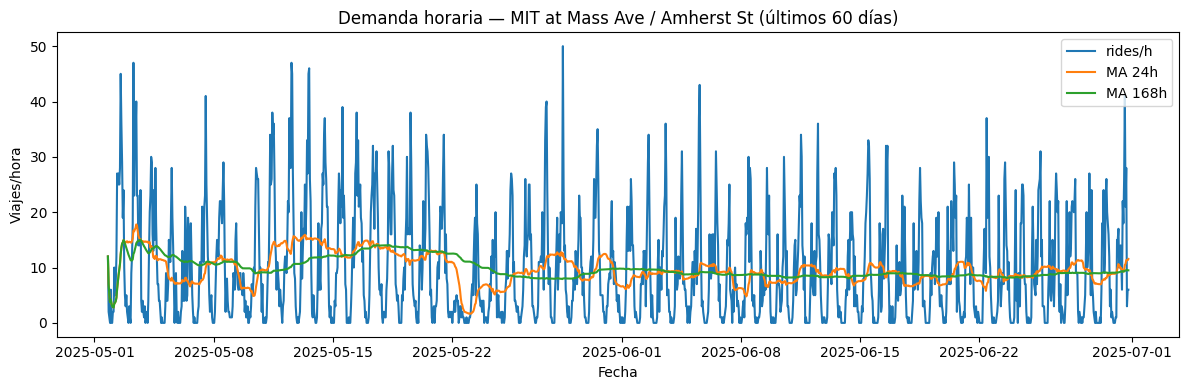

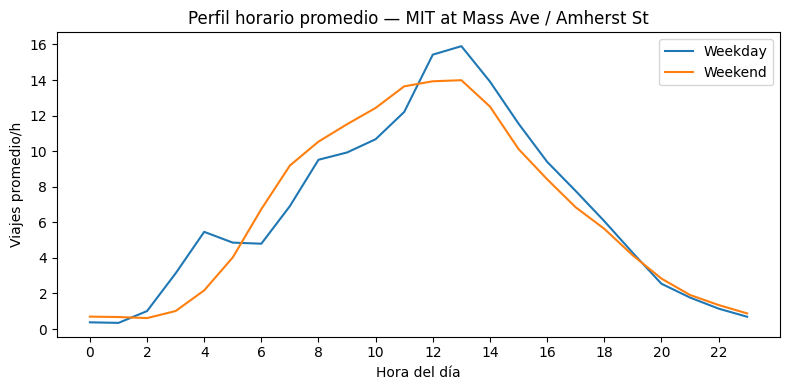

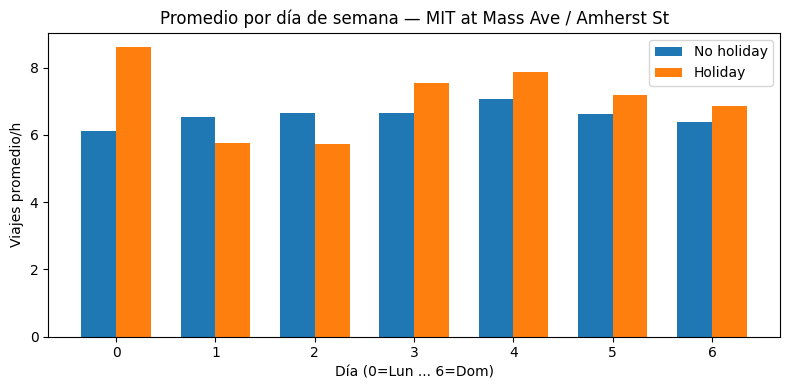

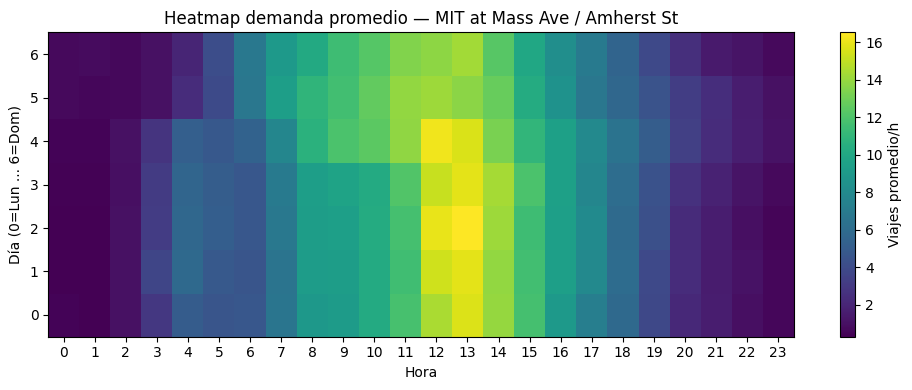

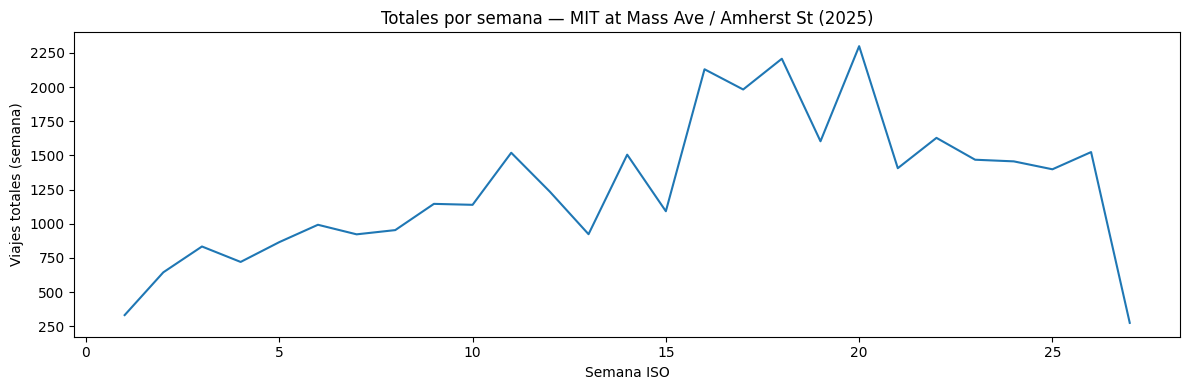

TOP 10 semanas por uso — MIT at Mass Ave / Amherst St:
     year  week   rides
400  2022    35  3744.0
402  2022    37  3673.0
354  2021    41  3311.0
351  2021    38  3265.0
349  2021    36  3217.0
401  2022    36  3189.0
350  2021    37  3184.0
403  2022    38  2978.0
505  2024    36  2950.0
506  2024    37  2932.0


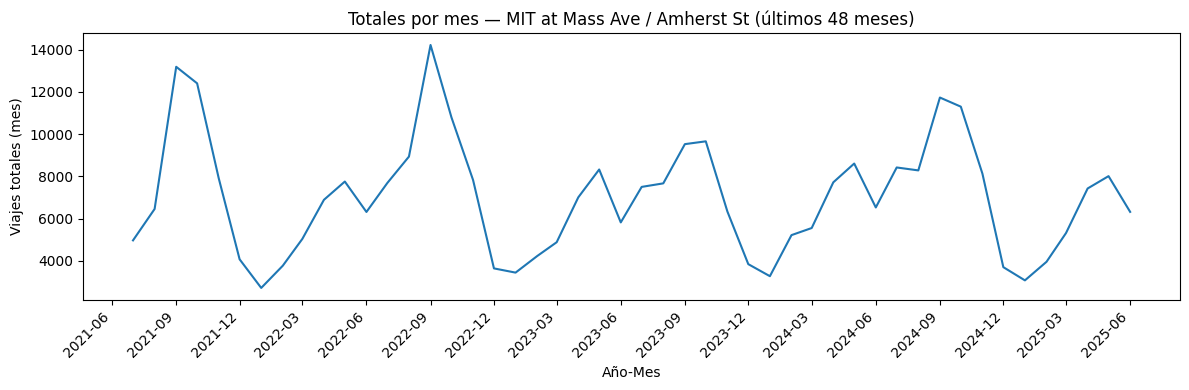

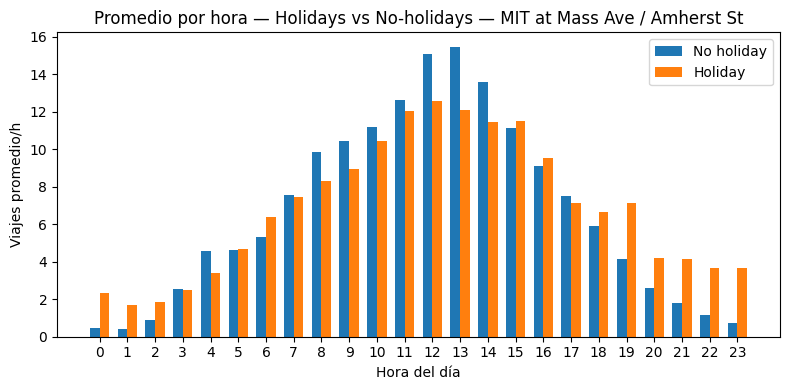

/tmp/ipython-input-4242323714.py:180: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topN = (pdf.groupby("start_station_name")["rides"]
/tmp/ipython-input-4242323714.py:192: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["hour", "start_station_name"])["rides"]


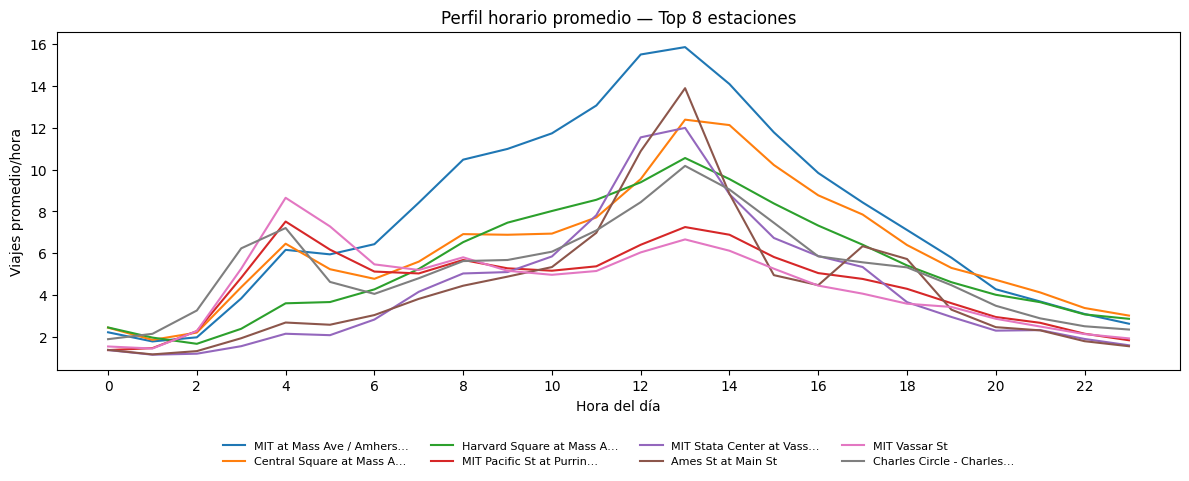

MIT at Mass Ave / Amhers… → MIT at Mass Ave / Amherst St
Central Square at Mass A… → Central Square at Mass Ave / Essex St
Harvard Square at Mass A… → Harvard Square at Mass Ave/ Dunster
MIT Pacific St at Purrin… → MIT Pacific St at Purrington St
MIT Stata Center at Vass… → MIT Stata Center at Vassar St / Main St
Ames St at Main St → Ames St at Main St
MIT Vassar St → MIT Vassar St
Charles Circle - Charles… → Charles Circle - Charles St at Cambridge St


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) Selección del DataFrame
# =========================
pdf = locals().get("pdf_opt", None) or locals().get("pdf_forecast", None)
assert pdf is not None, "No encuentro pdf_opt ni pdf_forecast."

pdf = pdf.copy()
pdf["ts_hour"] = pd.to_datetime(pdf["ts_hour"])
if "start_station_name" in pdf.columns and pdf["start_station_name"].dtype != "category":
    pdf["start_station_name"] = pdf["start_station_name"].astype("category")

# =========================
# Parámetros
# =========================
# Estación de trabajo (por defecto la más demandada)
top_station = (pdf.groupby("start_station_name")["rides"].sum()
               .sort_values(ascending=False).index[0])
STATION = top_station  # cambia por otra si quieres
N_DAYS_RECENT = 60     # días a visualizar en la serie reciente
TOP_N_STATIONS = 5     # para el comparativo de perfiles horarios
TOP_N_WEEKS = 10       # para imprimir top semanas por uso

print("Estación seleccionada:", STATION)

# =========================
# 1) Serie horaria de la estación (rellena horas faltantes con 0)
# =========================
one = (pdf[pdf["start_station_name"]==STATION]
       .loc[:, ["ts_hour","rides","start_station_name","is_holiday"] if "is_holiday" in pdf.columns else ["ts_hour","rides","start_station_name"]]
       .drop_duplicates(subset=["ts_hour"])
       .sort_values("ts_hour"))

# índice horario continuo
idx = pd.date_range(one["ts_hour"].min(), one["ts_hour"].max(), freq="H")
one = one.set_index("ts_hour").reindex(idx)
one["start_station_name"] = STATION
one["rides"] = one["rides"].fillna(0)
if "is_holiday" in one.columns:
    one["is_holiday"] = one["is_holiday"].fillna(False)

# variables derivadas
one["trip_hour"] = one.index.hour
one["trip_day_of_week"] = one.index.dayofweek  # 0=Lun..6=Dom
one["is_weekend"] = one["trip_day_of_week"].isin([5,6])
one["year"] = one.index.isocalendar().year.astype(int)
one["week"] = one.index.isocalendar().week.astype(int)
one["month"] = one.index.month

# recorte reciente
one_recent = one.loc[one.index.max()-pd.Timedelta(days=N_DAYS_RECENT):].copy()

# =========================
# 2) Serie reciente + medias móviles
# =========================
plt.figure(figsize=(12,4))
plt.plot(one_recent.index, one_recent["rides"], label="rides/h")
plt.plot(one_recent.index, one_recent["rides"].rolling(24, min_periods=1).mean(), label="MA 24h")
plt.plot(one_recent.index, one_recent["rides"].rolling(168, min_periods=1).mean(), label="MA 168h")
plt.title(f"Demanda horaria — {STATION} (últimos {N_DAYS_RECENT} días)")
plt.xlabel("Fecha"); plt.ylabel("Viajes/hora")
plt.legend(); plt.tight_layout(); plt.show()

# =========================
# 3) Perfil horario (weekday vs weekend)
# =========================
prof = (one.groupby(["is_weekend","trip_hour"])["rides"]
        .mean().unstack("is_weekend").rename(columns={False:"weekday", True:"weekend"}))
plt.figure(figsize=(8,4))
plt.plot(prof.index, prof["weekday"], label="Weekday")
plt.plot(prof.index, prof["weekend"], label="Weekend")
plt.title(f"Perfil horario promedio — {STATION}")
plt.xlabel("Hora del día"); plt.ylabel("Viajes promedio/h")
plt.xticks(range(0,24,2)); plt.legend(); plt.tight_layout(); plt.show()

# =========================
# 4) Promedio por día de semana (holiday vs no-holiday)
# =========================
if "is_holiday" in one.columns:
    dow_h = (one.groupby(["trip_day_of_week","is_holiday"])["rides"].mean().unstack("is_holiday"))
    dow_h = dow_h.rename(columns={False:"no_holiday", True:"holiday"}).reindex(range(7))
    plt.figure(figsize=(8,4))
    # barras lado a lado
    x = np.arange(7)
    width = 0.35
    plt.bar(x - width/2, dow_h["no_holiday"].values, width, label="No holiday")
    plt.bar(x + width/2, dow_h["holiday"].values, width, label="Holiday")
    plt.title(f"Promedio por día de semana — {STATION}")
    plt.xlabel("Día (0=Lun ... 6=Dom)"); plt.ylabel("Viajes promedio/h")
    plt.xticks(x, range(7))
    plt.legend(); plt.tight_layout(); plt.show()

# =========================
# 5) Heatmap Hora × Día de semana (promedio)
# =========================
mat = (one.groupby(["trip_day_of_week","trip_hour"])["rides"]
       .mean().reindex(index=range(7), level=0).unstack("trip_day_of_week").T)
plt.figure(figsize=(10,4))
im = plt.imshow(mat.values, aspect="auto", origin="lower")
plt.title(f"Heatmap demanda promedio — {STATION}")
plt.xlabel("Hora"); plt.ylabel("Día (0=Lun ... 6=Dom)")
plt.xticks(range(24), range(24)); plt.yticks(range(7), range(7))
cbar = plt.colorbar(im); cbar.set_label("Viajes promedio/h")
plt.tight_layout(); plt.show()

# =========================
# 6) Semanas más usadas del año (totales por (año, semana))
# =========================
wk = one.groupby(["year","week"])["rides"].sum().reset_index()
# gráfico de las últimas 52 semanas
last_year = wk["year"].max()
wk_last = wk[(wk["year"]==last_year)]
plt.figure(figsize=(12,4))
plt.plot(wk_last["week"], wk_last["rides"])
plt.title(f"Totales por semana — {STATION} ({last_year})")
plt.xlabel("Semana ISO"); plt.ylabel("Viajes totales (semana)")
plt.tight_layout(); plt.show()

# TOP semanas globales (sin limitar al último año)
top_weeks = wk.sort_values("rides", ascending=False).head(TOP_N_WEEKS)
print(f"TOP {TOP_N_WEEKS} semanas por uso — {STATION}:")
print(top_weeks)

# =========================
# =========================
# 7) Totales por mes (fix)
# =========================
import matplotlib.dates as mdates

N_MONTHS = 48  # muestra últimos 48 meses (ajusta a gusto)

# serie mensual con resample (start of month)
monthly = one["rides"].resample("MS").sum()
monthly_recent = monthly.iloc[-N_MONTHS:]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(monthly_recent.index, monthly_recent.values)
ax.set_title(f"Totales por mes — {STATION} (últimos {N_MONTHS} meses)")
ax.set_xlabel("Año-Mes")
ax.set_ylabel("Viajes totales (mes)")

# ticks cada 3 meses y formato YYYY-MM
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


# =========================
# 8) Holidays vs No-holidays por HORA DEL DÍA (promedio)
# =========================
if "is_holiday" in one.columns:
    hour_h = (one.groupby(["trip_hour","is_holiday"])["rides"].mean().unstack("is_holiday"))
    hour_h = hour_h.rename(columns={False:"no_holiday", True:"holiday"})
    plt.figure(figsize=(8,4))
    x = np.arange(24); width = 0.35
    plt.bar(x - width/2, hour_h["no_holiday"].values, width, label="No holiday")
    plt.bar(x + width/2, hour_h["holiday"].values, width, label="Holiday")
    plt.title(f"Promedio por hora — Holidays vs No-holidays — {STATION}")
    plt.xlabel("Hora del día"); plt.ylabel("Viajes promedio/h")
    plt.xticks(x, range(24))
    plt.legend(); plt.tight_layout(); plt.show()

# =========================
# 9) Comparativa Top-N estaciones (fix definitivo)
# =========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

TOP_N_STATIONS = 8
MAX_LABEL_LEN   = 24

# Top-N por demanda total
topN = (pdf.groupby("start_station_name")["rides"]
        .sum().nlargest(TOP_N_STATIONS).index.tolist())

# Trabajar SOLO con topN (¡esta es la clave!)
df_top = pdf.loc[pdf["start_station_name"].isin(topN),
                 ["start_station_name", "ts_hour", "rides"]].copy()

df_top["ts_hour"] = pd.to_datetime(df_top["ts_hour"])
df_top["hour"]    = df_top["ts_hour"].dt.hour

# Perfil horario promedio por estación (0..23)
prof_multi = (df_top
              .groupby(["hour", "start_station_name"])["rides"]
              .mean()
              .unstack("start_station_name")
              .reindex(columns=topN))  # conserva el orden del topN

def abbrev(name, k=MAX_LABEL_LEN):
    return (name[:k] + "…") if len(name) > k else name

fig, ax = plt.subplots(figsize=(12,5))
for st in prof_multi.columns:
    ax.plot(prof_multi.index, prof_multi[st], label=abbrev(st))

ax.set_title(f"Perfil horario promedio — Top {TOP_N_STATIONS} estaciones")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Viajes promedio/hora")
ax.set_xticks(range(0,24,2))

# Leyenda ordenada y compacta debajo del gráfico
ax.legend(
    ncol=min(TOP_N_STATIONS, 4),
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize=8,
    frameon=False
)

plt.tight_layout()
plt.show()

# (Opcional) mapping de etiquetas abreviadas → nombre completo
name_map = {abbrev(st): st for st in prof_multi.columns}
for k, v in name_map.items():
    print(f"{k} → {v}")



/tmp/ipython-input-972951437.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  STATION = (pdf.groupby("start_station_name")["rides"].sum()


Estación a modelar: MIT at Mass Ave / Amherst St


/tmp/ipython-input-972951437.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(one.index.min(), one.index.max(), freq="H")
/tmp/ipython-input-972951437.py:94: RuntimeWarning: divide by zero encountered in divide
  mape = float(np.mean(np.where(y!=0, np.abs((y - yhat)/y), 0))*100)


Validación (última semana) — MAE=3.45  RMSE=4.99  MAPE=45.06%


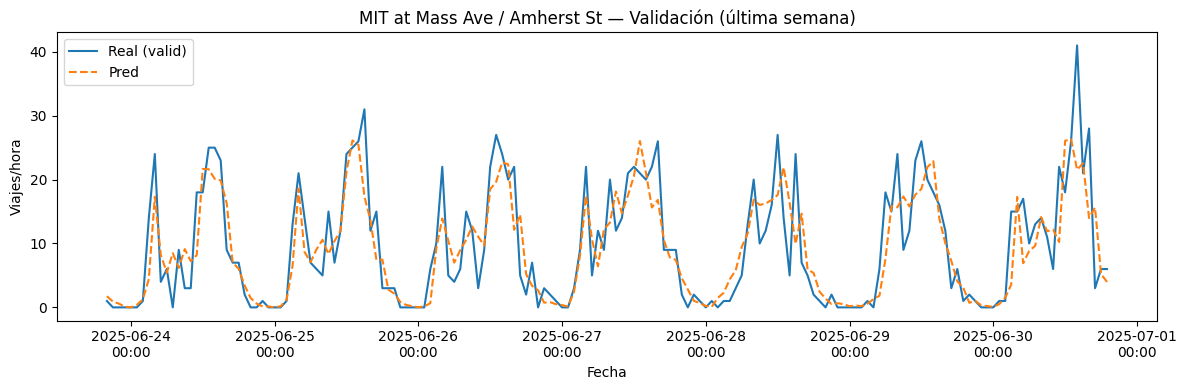

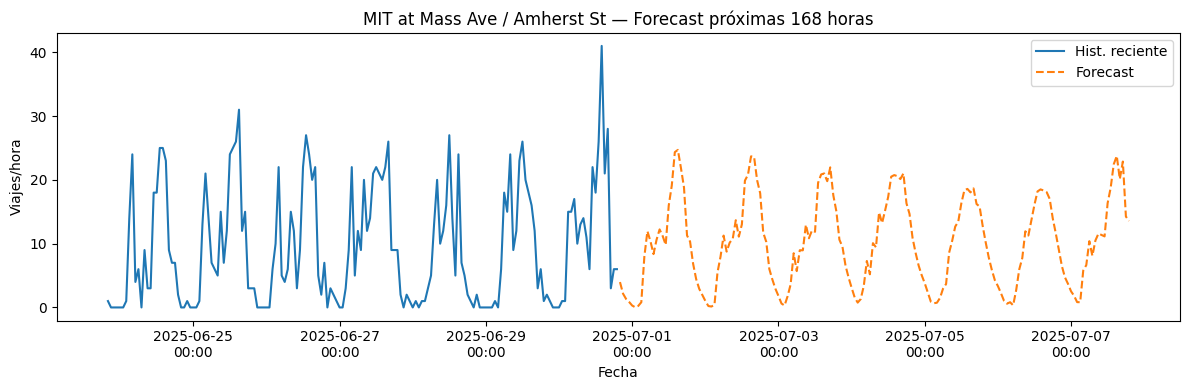

In [25]:
# ============================================================
# 0) SETUP
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# usa pdf_opt si existe; si no, pdf_forecast
pdf = locals().get("pdf_opt", None) or locals().get("pdf_forecast", None)
assert pdf is not None, "No encuentro pdf_opt ni pdf_forecast."

# Asegura tipos
pdf = pdf.copy()
pdf["ts_hour"] = pd.to_datetime(pdf["ts_hour"])
pdf["start_station_name"] = pdf["start_station_name"].astype("category")

# Parámetros
H = 24*7                      # horizonte = 1 semana
STATION = (pdf.groupby("start_station_name")["rides"].sum()
           .sort_values(ascending=False).index[0])   # usa la top por defecto
print("Estación a modelar:", STATION)

# (opcional) pip de xgboost si hiciera falta
try:
    from xgboost import XGBRegressor
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    from xgboost import XGBRegressor

# ============================================================
# 1) SERIE HORARIA CONTINUA (rellena huecos con 0)
# ============================================================
one = (pdf.loc[pdf["start_station_name"]==STATION, ["ts_hour","rides"]]
       .drop_duplicates(subset=["ts_hour"])
       .set_index("ts_hour").sort_index())

idx = pd.date_range(one.index.min(), one.index.max(), freq="H")
one = one.reindex(idx)
one["rides"] = one["rides"].fillna(0.0)

# ============================================================
# 2) FEATURE ENGINEERING (lags / rolling + calendarios)
# ============================================================
def make_features(df):
    df = df.copy()
    df["hour"]  = df.index.hour
    df["dow"]   = df.index.dayofweek
    df["month"] = df.index.month
    df["is_wend"] = (df["dow"]>=5).astype("int8")
    # lags más útiles para bike share
    for lag in [1, 24, 168]:
        df[f"lag_{lag}"] = df["rides"].shift(lag)
    # medias móviles (usamos shift(1) para no ver el futuro)
    for w in [3, 6, 12, 24, 168]:
        df[f"rmean_{w}"] = df["rides"].shift(1).rolling(w).mean()
    return df.dropna()

feats = make_features(one)

TARGET = "rides"
FEATURES = [c for c in feats.columns if c != TARGET]

# ============================================================
# 3) SPLIT TEMPORAL (última semana = validación)
# ============================================================
train = feats.iloc[:-H].copy()
valid = feats.iloc[-H:].copy()

X_tr, y_tr = train[FEATURES].values, train[TARGET].values
X_va, y_va = valid[FEATURES].values, valid[TARGET].values

# ============================================================
# 4) ENTRENAR MODELO (XGBoost)
# ============================================================
model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
)
model.fit(X_tr, y_tr)

# Validación
y_hat_va = model.predict(X_va)

def metrics(y, yhat):
    mae  = float(np.mean(np.abs(y - yhat)))
    rmse = float(np.sqrt(np.mean((y - yhat)**2)))
    mape = float(np.mean(np.where(y!=0, np.abs((y - yhat)/y), 0))*100)
    return mae, rmse, mape

mae, rmse, mape = metrics(y_va, y_hat_va)
print(f"Validación (última semana) — MAE={mae:.2f}  RMSE={rmse:.2f}  MAPE={mape:.2f}%")

# ============================================================
# 5) FORECAST FUTURO (próximas H horas) — recursivo
# ============================================================
def recursive_forecast(history_series, model, horizon):
    hist = history_series.copy()  # pandas Series con index horario y col 'rides'
    preds = []
    for i in range(1, horizon+1):
        t = hist.index.max() + pd.Timedelta(hours=1)
        # crea fila vacía al final
        hist.loc[t, "rides"] = np.nan
        # features para ese t (usando historial + predicciones ya agregadas)
        f = make_features(hist).iloc[[-1]][FEATURES]
        yhat = float(model.predict(f)[0])
        preds.append((t, yhat))
        # inserta la predicción como "observada" para siguientes lags/rolling
        hist.loc[t, "rides"] = yhat
    return pd.DataFrame(preds, columns=["ts_hour","yhat"]).set_index("ts_hour")

fcst = recursive_forecast(one, model, H)

# ============================================================
# 6) GRÁFICOS (validación + futuro)
# ============================================================
import matplotlib.dates as mdates

# a) Validación: real vs predicción
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(valid.index, y_va, label="Real (valid)")
ax.plot(valid.index, y_hat_va, label="Pred", linestyle="--")
ax.set_title(f"{STATION} — Validación (última semana)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Viajes/hora")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(); plt.tight_layout(); plt.show()

# b) Futuro (próximas H horas)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(one.index[-H:], one["rides"].iloc[-H:], label="Hist. reciente")
ax.plot(fcst.index, fcst["yhat"], label="Forecast", linestyle="--")
ax.set_title(f"{STATION} — Forecast próximas {H} horas")
ax.set_xlabel("Fecha"); ax.set_ylabel("Viajes/hora")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(); plt.tight_layout(); plt.show()

# ============================================================


/tmp/ipython-input-1257608474.py:18: RuntimeWarning: invalid value encountered in divide
  return float(np.mean(np.where(denom > 0, 2.0*np.abs(y - yhat)/denom, 0.0)) * 100)



===== MÉTRICAS GLOBALES (Validación última semana) =====
                     MAE      RMSE     sMAPE%      MAPE%  ME (bias)  \
Model           3.453760  4.991178  76.166753  55.662525  -0.458880   
SeasonalNaive   4.083333  6.056284  60.982980  50.631530  -1.297619   
Skill_vs_Naive  0.154181  0.175868  -0.248984        NaN        NaN   

                     MPE%  BiasRatio%      MASE  
Model           18.389910   -4.830316  0.982793  
SeasonalNaive   -5.315144  -13.659148  1.161943  
Skill_vs_Naive        NaN         NaN       NaN  

— Error por HORA del día —
    hour       MAE      RMSE      Bias
0      0  0.128573  0.177795  0.126739
1      1  0.361875  0.442635 -0.037270
2      2  1.223617  2.121626 -0.462451
3      3  4.416868  6.190629 -4.049298
4      4  4.090461  4.695297 -2.098085
5      5  5.391472  5.795816 -0.205952
6      6  3.606174  4.929559 -1.453864
7      7  3.347210  4.053430  1.977374
8      8  4.452019  5.117649 -2.817421
9      9  4.987125  5.699028  3.082568


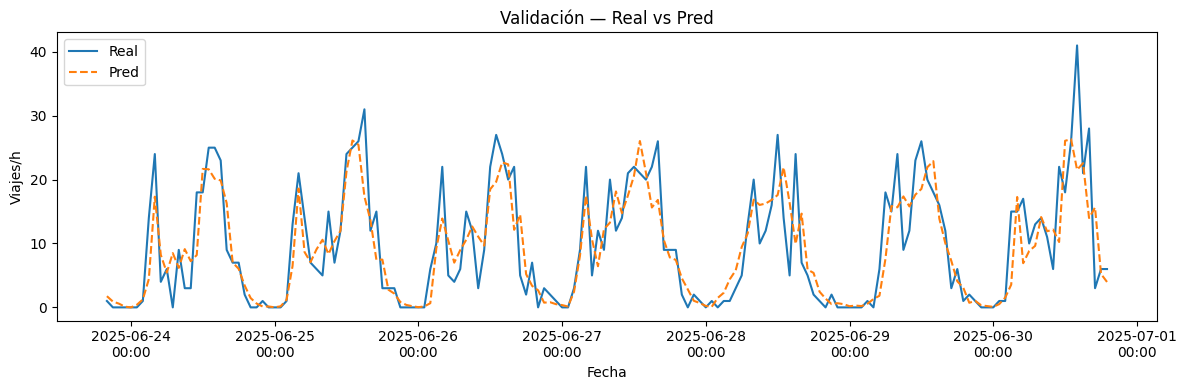

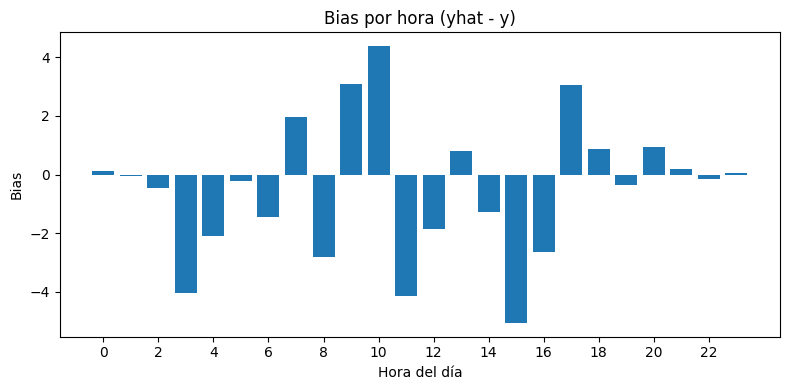

In [27]:
# ============================================================
# DIAGNÓSTICOS DE ERROR Y BIAS (robusto)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- helpers robustos --------
def _finite(y, yhat):
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    mask = np.isfinite(y) & np.isfinite(yhat)
    return y[mask], yhat[mask]

def smape_safe(y, yhat):
    y, yhat = _finite(y, yhat)
    denom = np.abs(y) + np.abs(yhat)
    return float(np.mean(np.where(denom > 0, 2.0*np.abs(y - yhat)/denom, 0.0)) * 100)

def mape_safe(y, yhat):
    y, yhat = _finite(y, yhat)
    nz = y != 0
    return float(np.mean(np.abs((y[nz] - yhat[nz]) / y[nz])) * 100) if np.any(nz) else np.nan

def mpe_safe(y, yhat):
    y, yhat = _finite(y, yhat)
    nz = y != 0
    return float(np.mean(((yhat[nz] - y[nz]) / y[nz])) * 100) if np.any(nz) else np.nan

def metrics_all(y, yhat, mase_scale=None):
    y, yhat = _finite(y, yhat)
    err = yhat - y
    ae  = np.abs(err)
    mae = float(ae.mean())
    rmse = float(np.sqrt(np.mean(err**2)))
    me   = float(err.mean())                                  # bias aditivo
    mpe  = mpe_safe(y, yhat)                                  # bias relativo %
    bias_ratio = float((yhat.sum()/y.sum() - 1) * 100) if y.sum()!=0 else np.nan
    sm   = smape_safe(y, yhat)
    mp   = mape_safe(y, yhat)
    mase = float(np.mean(ae / mase_scale)) if mase_scale is not None else np.nan
    return {"MAE": mae, "RMSE": rmse, "sMAPE%": sm, "MAPE%": mp,
            "ME (bias)": me, "MPE%": mpe, "BiasRatio%": bias_ratio, "MASE": mase}

# -------- series de validación --------
y_true = y_va
y_pred = y_hat_va

# -------- naive estacional (lag=168h) --------
lag = 168
y_pred_naive = one["rides"].shift(lag).iloc[-H:].values  # mismo horizonte

# -------- escala para MASE (error abs del naive en TRAIN) --------
insample = one["rides"].values
insample_naive_abs_err = np.abs(insample[lag:-H] - insample[:-H-lag])
mase_scale = float(np.mean(insample_naive_abs_err)) if insample_naive_abs_err.size else np.nan

# -------- métricas globales --------
m_model = metrics_all(y_true, y_pred, mase_scale=mase_scale)
m_naive = metrics_all(y_true, y_pred_naive, mase_scale=mase_scale)

# skill vs naive
skill_rmse = 1 - (m_model["RMSE"] / max(m_naive["RMSE"], 1e-9))
skill_mae  = 1 - (m_model["MAE"]  / max(m_naive["MAE"],  1e-9))
skill_smape= 1 - (m_model["sMAPE%"] / max(m_naive["sMAPE%"], 1e-9))

summary = pd.DataFrame([m_model, m_naive], index=["Model", "SeasonalNaive"])
summary.loc["Skill_vs_Naive", ["RMSE","MAE","sMAPE%"]] = [skill_rmse, skill_mae, skill_smape]
print("\n===== MÉTRICAS GLOBALES (Validación última semana) =====")
print(summary)

# -------- tabla de errores por segmentos (fix holiday join) --------
valid_idx = valid.index  # DatetimeIndex de validación
df_err = pd.DataFrame({
    "ts_hour": valid_idx, "y": y_true, "yhat": y_pred
}).set_index("ts_hour")
df_err["err"] = df_err["yhat"] - df_err["y"]
df_err["abs_err"] = np.abs(df_err["err"])
df_err["hour"] = df_err.index.hour
df_err["dow"]  = df_err.index.dayofweek

# join robusto de holidays (si existe y es consistente por hora)
if "is_holiday" in pdf.columns:
    hol = pdf[["ts_hour","is_holiday"]].drop_duplicates(subset=["ts_hour"]).copy()
    hol["ts_hour"] = pd.to_datetime(hol["ts_hour"])
    hol = hol.set_index("ts_hour").sort_index()              # <-- usar su propia columna
    df_err = df_err.join(hol[["is_holiday"]], how="left")
    df_err["is_holiday"] = df_err["is_holiday"].fillna(False).astype(bool)
else:
    df_err["is_holiday"] = False

# cortes
by_hour = df_err.groupby("hour").agg(
    MAE=("abs_err","mean"),
    RMSE=("err", lambda x: np.sqrt(np.mean(x**2))),
    Bias=("err","mean")
).reset_index()

by_dow = df_err.groupby("dow").agg(
    MAE=("abs_err","mean"),
    RMSE=("err", lambda x: np.sqrt(np.mean(x**2))),
    Bias=("err","mean")
).reset_index()

by_hol = df_err.groupby("is_holiday").agg(
    MAE=("abs_err","mean"),
    RMSE=("err", lambda x: np.sqrt(np.mean(x**2))),
    Bias=("err","mean")
).reset_index().rename(columns={"is_holiday":"holiday"})

print("\n— Error por HORA del día —");        print(by_hour)
print("\n— Error por DÍA de semana —");       print(by_dow)
print("\n— Error: Holidays vs No-holidays —");print(by_hol)

# -------- gráficos rápidos --------
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_err.index, df_err["y"], label="Real")
ax.plot(df_err.index, df_err["yhat"], label="Pred", linestyle="--")
ax.set_title("Validación — Real vs Pred")
ax.set_xlabel("Fecha"); ax.set_ylabel("Viajes/h")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(by_hour["hour"], by_hour["Bias"])
ax.set_title("Bias por hora (yhat - y)")
ax.set_xlabel("Hora del día"); ax.set_ylabel("Bias")
ax.set_xticks(range(0,24,2)); plt.tight_layout(); plt.show()


In [28]:
def wmape(y, yhat):
    num = np.sum(np.abs(y - yhat))
    den = np.sum(np.abs(y)) + 1e-9
    return 100 * num / den

def nrmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2)) / (np.mean(y) + 1e-9)

print("wMAPE% (modelo):", wmape(y_va, y_hat_va))
print("NRMSE  (modelo):", nrmse(y_va, y_hat_va))
print("wMAPE% (naive): ", wmape(y_va, one["rides"].shift(168).iloc[-H:].values))
print("NRMSE  (naive): ", nrmse(y_va, one["rides"].shift(168).iloc[-H:].values))


wMAPE% (modelo): 36.35537319214497
NRMSE  (modelo): 0.5253872079566868
wMAPE% (naive):  42.98245614032395
NRMSE  (naive):  0.637503540120307


In [29]:
# df_err ya lo tienes; si no:
df_err = pd.DataFrame({"y": y_va, "yhat": y_hat_va}, index=valid.index)
df_err["err"] = df_err["yhat"] - df_err["y"]
df_err["hour"] = df_err.index.hour
df_err["dow"]  = df_err.index.dayofweek

# A) Corrección por HORA
hour_bias = df_err.groupby("hour")["err"].mean().to_dict()

fcst_adj = fcst.copy()
fcst_adj["hour"] = fcst_adj.index.hour
fcst_adj["yhat_adj"] = fcst_adj["yhat"] - fcst_adj["hour"].map(hour_bias).fillna(0.0)
fcst_adj["yhat_adj"] = fcst_adj["yhat_adj"].clip(lower=0)  # no negativos

# B) (Opcional) Corrección más fina por DOW×HORA
dow_hour_bias = df_err.groupby(["dow","hour"])["err"].mean()
def corr(ts):
    return dow_hour_bias.get((ts.weekday(), ts.hour), 0.0)

fcst_adj2 = fcst.copy()
fcst_adj2["yhat_adj"] = [max(0.0, y - corr(ts)) for ts, y in fcst["yhat"].items()]


In [30]:
# Fourier diarios/semanales
def add_fourier(df, period, K, col="rides"):
    import math
    df = df.copy()
    t = (df.index.view('i8') // 10**9)  # segundos desde epoch
    # escalar t a [0,1) por periodo en segundos
    P = period * 3600.0
    x = (t % P) / P
    for k in range(1, K+1):
        df[f"fourier_sin_{period}_{k}"] = np.sin(2*np.pi*k*x)
        df[f"fourier_cos_{period}_{k}"] = np.cos(2*np.pi*k*x)
    return df

feat2 = one.copy()
for w in [24,168]:
    feat2[f"rsum_{w}"] = feat2["rides"].shift(1).rolling(w).sum()
    feat2[f"rstd_{w}"] = feat2["rides"].shift(1).rolling(w).std()

feat2 = add_fourier(feat2, period=24,  K=3)
feat2 = add_fourier(feat2, period=168, K=2)
feat2 = make_features(feat2).dropna()


In [31]:
from xgboost import XGBRegressor
model = XGBRegressor(
    objective="reg:tweedie",
    tweedie_variance_power=1.4,  # 1–2; prueba 1.2–1.6
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
)
model.fit(feat2.iloc[:-H].drop(columns=["rides"]).values,
          feat2.iloc[:-H]["rides"].values,
          eval_set=[(feat2.iloc[-H:].drop(columns=["rides"]).values,
                     feat2.iloc[-H:]["rides"].values)],
          verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

— Validación (última semana) —
MAE   : 3.332
RMSE  : 4.779
wMAPE : 35.08%
NRMSE : 0.503

Comparado con Naive (lag 168h):
MAE   : 4.083
RMSE  : 6.056
wMAPE : 42.98%
NRMSE : 0.638


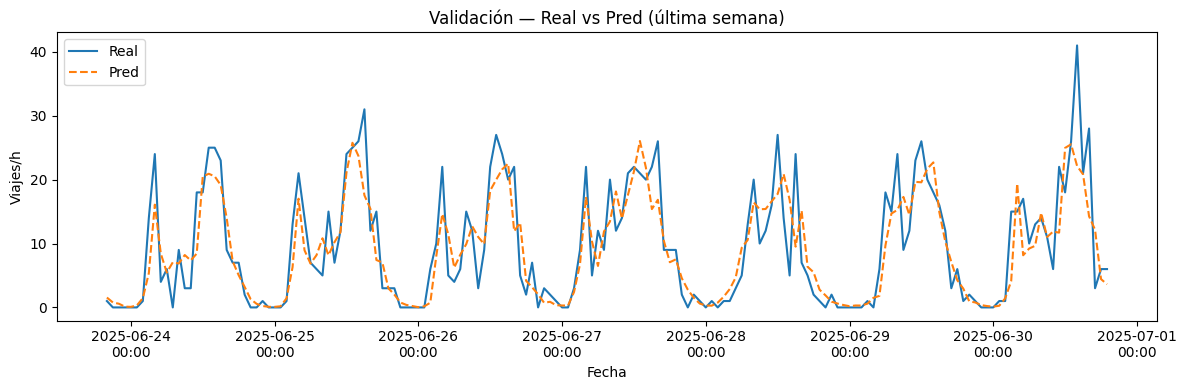

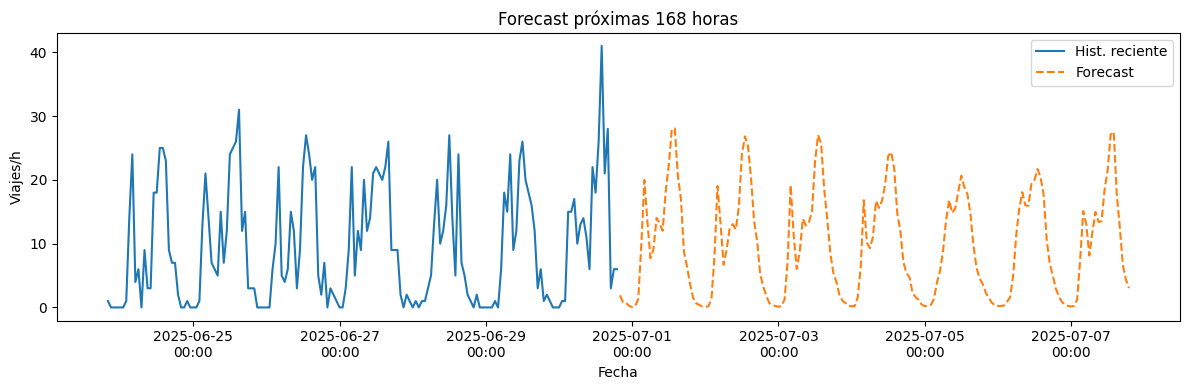

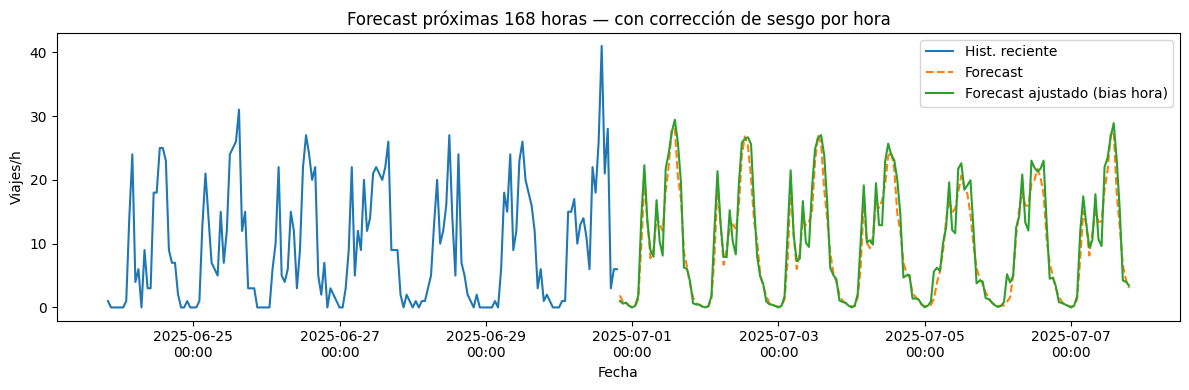

In [32]:
# ============================================================
# 1) EVALUACIÓN EN VALIDACIÓN + SKILL VS NAIVE
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# columnas de entrada usadas en el modelo (toman el orden de feat2)
FEATURES2 = [c for c in feat2.columns if c != "rides"]

X_val = feat2.iloc[-H:][FEATURES2].values
y_val = feat2.iloc[-H:]["rides"].values
y_hat_val = model.predict(X_val)

def wmape(y, yhat):
    num = np.sum(np.abs(y - yhat)); den = np.sum(np.abs(y)) + 1e-9
    return 100 * num / den

def nrmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2)) / (np.mean(y) + 1e-9)

# naive estacional (168h)
y_hat_naive = one["rides"].shift(168).iloc[-H:].values

print("— Validación (última semana) —")
print(f"MAE   : {np.mean(np.abs(y_val - y_hat_val)):.3f}")
print(f"RMSE  : {np.sqrt(np.mean((y_val - y_hat_val)**2)):.3f}")
print(f"wMAPE : {wmape(y_val, y_hat_val):.2f}%")
print(f"NRMSE : {nrmse(y_val, y_hat_val):.3f}")
print("\nComparado con Naive (lag 168h):")
print(f"MAE   : {np.mean(np.abs(y_val - y_hat_naive)):.3f}")
print(f"RMSE  : {np.sqrt(np.mean((y_val - y_hat_naive)**2)):.3f}")
print(f"wMAPE : {wmape(y_val, y_hat_naive):.2f}%")
print(f"NRMSE : {nrmse(y_val, y_hat_naive):.3f}")

# gráfico validación
fig, ax = plt.subplots(figsize=(12,4))
t_idx = feat2.iloc[-H:].index
ax.plot(t_idx, y_val, label="Real")
ax.plot(t_idx, y_hat_val, "--", label="Pred")
ax.set_title("Validación — Real vs Pred (última semana)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Viajes/h")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(); plt.tight_layout(); plt.show()

# ============================================================
# 2) FORECAST PRÓXIMAS H HORAS (usando mismas features)
# ============================================================

# helpers Fourier (periodos en horas)
import numpy as np
def fourier_features_for_ts(ts, period_hours, K):
    feats = {}
    P = period_hours * 3600.0
    # usar .value (ns desde epoch) y llevar a segundos
    seconds = (ts.value // 10**9) % P
    x = seconds / P
    for k in range(1, K+1):
        feats[f"fourier_sin_{period_hours}_{k}"] = np.sin(2*np.pi*k*x)
        feats[f"fourier_cos_{period_hours}_{k}"] = np.cos(2*np.pi*k*x)
    return feats

# construir fila de features para un instante ts basado en historial 'hist' (serie rides indexada por hora)
def build_feature_row(ts, hist_series):
    row = {}
    row["hour"]   = ts.hour
    row["dow"]    = ts.dayofweek
    row["month"]  = ts.month
    row["is_wend"]= 1 if ts.weekday()>=5 else 0

    # lags
    last = hist_series
    row["lag_1"]   = last.iloc[-1] if len(last) >= 1 else 0.0
    row["lag_24"]  = last.iloc[-24] if len(last) >= 24 else row["lag_1"]
    row["lag_168"] = last.iloc[-168] if len(last) >= 168 else row["lag_24"]

    # rolling means
    for w in [3,6,12,24,168]:
        row[f"rmean_{w}"] = last.iloc[-w:].mean() if len(last) >= w else last.mean()

    # rolling sum / std (las añadiste en feat2)
    for w in [24,168]:
        row[f"rsum_{w}"] = last.iloc[-w:].sum() if len(last) >= w else last.sum()
        row[f"rstd_{w}"] = (last.iloc[-w:].std(ddof=0) if len(last) >= w else last.std(ddof=0))

    # Fourier diaria y semanal (mismos K que usaste al entrenar)
    row.update(fourier_features_for_ts(ts, 24, 3))
    row.update(fourier_features_for_ts(ts, 168, 2))

    # asegurar todas las columnas esperadas por el modelo (FILL 0 si falta alguna)
    return pd.DataFrame([{col: row.get(col, 0.0) for col in FEATURES2}], index=[ts])

# historial base (serie continua ya creada en tu pipeline)
hist = one["rides"].copy()  # pandas Series indexada por hora
preds = []
for i in range(H):
    ts = hist.index.max() + pd.Timedelta(hours=1)
    X_row = build_feature_row(ts, hist)[FEATURES2].values
    yhat = float(model.predict(X_row)[0])
    yhat = max(0.0, yhat)  # no negativos
    preds.append((ts, yhat))
    # agregamos predicción al historial para poder computar lags/rolling del siguiente paso
    hist.loc[ts] = yhat

fcst = pd.DataFrame(preds, columns=["ts_hour","yhat"]).set_index("ts_hour")

# gráfico forecast
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(one.index[-H:], one["rides"].iloc[-H:], label="Hist. reciente")
ax.plot(fcst.index, fcst["yhat"], "--", label="Forecast")
ax.set_title(f"Forecast próximas {H} horas")
ax.set_xlabel("Fecha"); ax.set_ylabel("Viajes/h")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(); plt.tight_layout(); plt.show()

# ============================================================
# 3) (OPCIONAL) CORRECCIÓN DE SESGO POR HORA (calibración)
# ============================================================
df_err = pd.DataFrame({"y": y_val, "yhat": y_hat_val}, index=feat2.iloc[-H:].index)
df_err["err"]  = df_err["yhat"] - df_err["y"]
hour_bias = df_err.groupby(df_err.index.hour)["err"].mean().to_dict()

fcst_adj = fcst.copy()
fcst_adj["hour"] = fcst_adj.index.hour
fcst_adj["yhat_adj"] = (fcst_adj["yhat"] - fcst_adj["hour"].map(hour_bias).fillna(0.0)).clip(lower=0.0)

# gráfico forecast ajustado
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(one.index[-H:], one["rides"].iloc[-H:], label="Hist. reciente")
ax.plot(fcst.index, fcst["yhat"], "--", label="Forecast")
ax.plot(fcst_adj.index, fcst_adj["yhat_adj"], label="Forecast ajustado (bias hora)")
ax.set_title(f"Forecast próximas {H} horas — con corrección de sesgo por hora")
ax.set_xlabel("Fecha"); ax.set_ylabel("Viajes/h")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.legend(); plt.tight_layout(); plt.show()

